## XGBoost - pair distribution function (PDF) - number of atoms 2bins 5050

In [ ]:
# https://medium.com/@ocaelen/exploring-the-novel-features-of-xgboost-2-0-1cf39919577f

In [1]:
import numpy as np
import pandas as pd
import h5py
from debyecalculator import DebyeCalculator
from ase.io import read
import glob
import os
import sys
import random
import tiktoken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

random.seed(42)
np.random.seed(42)

/home/vicky/anaconda3/envs/debyecalculator_env/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def process_xyz_files():
    # Initialise DebyeCalculator object
    calc = DebyeCalculator()
    print(calc)
    
    # Load XYZ files
    XYZ_files = sorted(glob.glob("../xyz_files/*.xyz"))
    random.shuffle(XYZ_files)

    # Calculate Pair Distribution Function for all XYZ files
    scattering_files = []
    structure_types = []
    num_atoms = []

    for iter, xyz_file in enumerate(XYZ_files):
        # Extract structure type
        structure_type = os.path.basename(xyz_file).split('_')[0]

        # Calculate the scattering pattern
        scatt_x, scatt_Int = calc.gr(structure_source=xyz_file)

        # Normalise the scattering files
        scatt_Int /= max(scatt_Int)
        scattering_files.append(scatt_Int)

        # Increment the count for this structure type
        structure_types.append(structure_type)

        atoms = read(xyz_file)
        num_atoms.append(len(atoms))

    return scattering_files, structure_types, num_atoms

In [3]:
# Simulate scattering data
scattering_files, structure_types, num_atoms = process_xyz_files()

/tmp/ipykernel_13820/1612413307.py:3: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator()


DebyeCalculator{'qmin': 1.0, 'qmax': 30.0, 'qdamp': 0.04, 'qstep': 0.05, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


In [4]:
len(scattering_files[0])

2000

In [5]:
np.set_printoptions(threshold=sys.maxsize)

In [6]:
scattering_files[0]

array([ 0.00000000e+00, -1.24081259e-03, -2.43981788e-03, -3.55886901e-03,
       -4.56686504e-03, -5.44242794e-03, -6.17583841e-03, -6.76981779e-03,
       -7.23938225e-03, -7.61045050e-03, -7.91762862e-03, -8.20107665e-03,
       -8.50310456e-03, -8.86432454e-03, -9.32015758e-03, -9.89775546e-03,
       -1.06134415e-02, -1.14714708e-02, -1.24634868e-02, -1.35693504e-02,
       -1.47587219e-02, -1.59940217e-02, -1.72333848e-02, -1.84345916e-02,
       -1.95586290e-02, -2.05732044e-02, -2.14555021e-02, -2.21943278e-02,
       -2.27909349e-02, -2.32591350e-02, -2.36239322e-02, -2.39193980e-02,
       -2.41856966e-02, -2.44655330e-02, -2.48004626e-02, -2.52271071e-02,
       -2.57741194e-02, -2.64594071e-02, -2.72887163e-02, -2.82550789e-02,
       -2.93392893e-02, -3.05116437e-02, -3.17345411e-02, -3.29658240e-02,
       -3.41622792e-02, -3.52836587e-02, -3.62959877e-02, -3.71749178e-02,
       -3.79074812e-02, -3.84935588e-02, -3.89457569e-02, -3.92884202e-02,
       -3.95554863e-02, -

In [7]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0])))
num_tokens

19524

In [8]:
len(scattering_files[0].round(3)[::15])

134

In [9]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0].round(3)[::15])))
num_tokens

551

In [10]:
scattering_patterns = []
for i in np.arange(len(scattering_files)):
    pattern = scattering_files[i].round(3)[::15]
    scattering_patterns.append(pattern)

In [11]:
len(scattering_patterns[0])

134

### distribution of num of atoms values in the dataset

(array([285., 247., 228., 171., 171., 209., 133., 152., 171., 190.]),
 array([  6. ,  15.4,  24.8,  34.2,  43.6,  53. ,  62.4,  71.8,  81.2,
         90.6, 100. ]),
 <BarContainer object of 10 artists>)

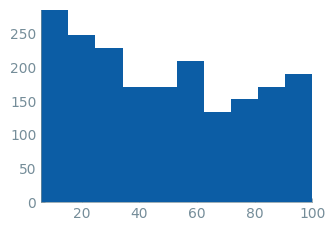

In [12]:
plt.figure(figsize=(3.5, 2.5))
plt.hist(num_atoms)

### make balanced dataset 2bins 5050

In [13]:
scattering_patterns = np.array(scattering_patterns)
num_atoms = np.array(num_atoms)

In [14]:
bins = 2

In [15]:
num_atoms_2bins_5050 = pd.qcut(num_atoms, bins, labels=False)
print(np.unique(num_atoms_2bins_5050, return_counts=True))
print(pd.qcut(num_atoms, bins, retbins=True, labels=False)[1])

(array([0, 1]), array([1026,  931]))
[  6.  48. 100.]


In [16]:
num_atoms_2bins_5050

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [17]:
class_indices = {i: np.where(num_atoms_2bins_5050 == i)[0] for i in np.unique(num_atoms_2bins_5050)}

In [18]:
for cat in class_indices:
    print(cat)

0
1


In [19]:
for indices in class_indices.values():
    print(len(indices))

1026
931


### prepare clasification dataset for number of atoms

In [20]:
MAX_TEST_DATA = 100
train_size = 1800

In [21]:
indices = np.arange(len(num_atoms))
indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [22]:
train_indices, val_test_indices = train_test_split(
    indices, 
    train_size=train_size,
    test_size=min(len(indices)-train_size, MAX_TEST_DATA),
    random_state=42,
    stratify=num_atoms_2bins_5050,
)

In [23]:
len(train_indices)

1800

In [24]:
len(val_test_indices)

100

In [25]:
y_val_test = num_atoms_2bins_5050[val_test_indices]

In [26]:
np.unique(y_val_test, return_counts=True)

(array([0, 1]), array([52, 48]))

In [27]:
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=0.5, 
    random_state=42,
    stratify=y_val_test
)

In [28]:
len(val_indices)

50

In [29]:
len(test_indices)

50

In [30]:
X_train, y_train = scattering_patterns[train_indices], num_atoms_2bins_5050[train_indices]
X_val, y_val = scattering_patterns[val_indices], num_atoms_2bins_5050[val_indices]
X_test, y_test = scattering_patterns[test_indices], num_atoms_2bins_5050[test_indices]

In [31]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([944, 856]))

In [32]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([26, 24]))

In [33]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([26, 24]))

In [34]:
X_train[0]

array([ 0.   , -0.012, -0.021, -0.031, -0.043, -0.054, -0.061, -0.071,
       -0.083, -0.091, -0.096, -0.105, -0.116, -0.12 , -0.113,  0.249,
        0.972,  0.024, -0.139, -0.14 , -0.149, -0.142,  0.046,  0.018,
       -0.142, -0.102,  0.04 ,  0.171,  0.125, -0.104,  0.22 ,  0.147,
       -0.069, -0.123, -0.121, -0.084, -0.081, -0.058,  0.019,  0.008,
        0.126,  0.031,  0.014,  0.037, -0.055, -0.019,  0.064, -0.051,
       -0.062, -0.034, -0.021,  0.002,  0.018, -0.001,  0.147,  0.04 ,
       -0.021, -0.04 , -0.01 ,  0.01 , -0.018, -0.002, -0.023, -0.032,
       -0.03 ,  0.036,  0.035,  0.029,  0.004,  0.037, -0.005, -0.028,
       -0.023, -0.016, -0.016, -0.017, -0.013, -0.007,  0.01 ,  0.057,
        0.027, -0.013,  0.001,  0.002, -0.   , -0.016, -0.019, -0.018,
       -0.009, -0.012, -0.01 ,  0.027,  0.017,  0.015,  0.021, -0.008,
       -0.008, -0.005, -0.004, -0.004, -0.009, -0.01 , -0.009,  0.001,
        0.018,  0.033, -0.002,  0.004,  0.004, -0.003, -0.008, -0.007,
      

### train and evaluate classifier

In [38]:
clf = XGBClassifier(
    n_estimators=500, 
    random_state=42, 
    early_stopping_rounds=10, 
    #use_label_encoder=False, 
    eval_metric='logloss'
)

In [39]:
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.49173	validation_1-logloss:0.51120
[1]	validation_0-logloss:0.36754	validation_1-logloss:0.41384
[2]	validation_0-logloss:0.28345	validation_1-logloss:0.31192
[3]	validation_0-logloss:0.22157	validation_1-logloss:0.24406
[4]	validation_0-logloss:0.17815	validation_1-logloss:0.19369
[5]	validation_0-logloss:0.14534	validation_1-logloss:0.16408
[6]	validation_0-logloss:0.12106	validation_1-logloss:0.14287
[7]	validation_0-logloss:0.10225	validation_1-logloss:0.12368
[8]	validation_0-logloss:0.08525	validation_1-logloss:0.10060
[9]	validation_0-logloss:0.07272	validation_1-logloss:0.08674
[10]	validation_0-logloss:0.06247	validation_1-logloss:0.07595
[11]	validation_0-logloss:0.05539	validation_1-logloss:0.06766
[12]	validation_0-logloss:0.04871	validation_1-logloss:0.06140
[13]	validation_0-logloss:0.04341	validation_1-logloss:0.05698
[14]	validation_0-logloss:0.03827	validation_1-logloss:0.05002
[15]	validation_0-logloss:0.03457	validation_1-logloss:0.04421
[1

[129]	validation_0-logloss:0.00268	validation_1-logloss:0.00622
[130]	validation_0-logloss:0.00266	validation_1-logloss:0.00611
[131]	validation_0-logloss:0.00265	validation_1-logloss:0.00604
[132]	validation_0-logloss:0.00263	validation_1-logloss:0.00602
[133]	validation_0-logloss:0.00262	validation_1-logloss:0.00596
[134]	validation_0-logloss:0.00262	validation_1-logloss:0.00587
[135]	validation_0-logloss:0.00261	validation_1-logloss:0.00591
[136]	validation_0-logloss:0.00260	validation_1-logloss:0.00594
[137]	validation_0-logloss:0.00258	validation_1-logloss:0.00602
[138]	validation_0-logloss:0.00257	validation_1-logloss:0.00601
[139]	validation_0-logloss:0.00257	validation_1-logloss:0.00589
[140]	validation_0-logloss:0.00256	validation_1-logloss:0.00591
[141]	validation_0-logloss:0.00255	validation_1-logloss:0.00584
[142]	validation_0-logloss:0.00254	validation_1-logloss:0.00583
[143]	validation_0-logloss:0.00253	validation_1-logloss:0.00587
[144]	validation_0-logloss:0.00252	valid

[258]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
[259]	validation_0-logloss:0.00194	validation_1-logloss:0.00446


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0])

In [41]:
np.unique(y_pred)

array([0, 1])

In [42]:
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

In [43]:
acc, f1_macro, f1_micro, f1_weighted, kappa

(1.0, 1.0, 1.0, 1.0, 1.0)

In [44]:
def prepare_dataset_classification(
    scattering_patterns, 
    num_atoms,
    bins=2,
    max_test_data=100, 
    train_size=1800, 
    random_state=42
):
    """
    Prepares the dataset for classification by splitting it into training, validation, and test sets.

    Parameters:
    scattering_patterns (list or numpy.ndarray): The scattering patterns for each structure.
    num_atoms (list of str): The number of atoms for each scattering pattern.
    bins (int): Number of classes.
    train_size (int): The number of samples used for training.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set labels.
        - X_val (numpy.ndarray): The validation set features.
        - y_val (numpy.ndarray): The validation set labels.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set labels.
    """
    scattering_patterns = np.array(scattering_patterns)
    num_atoms = np.array(num_atoms)
    
    # Create a dictionary to store indices of each class
    num_atoms_2bins_5050 = pd.qcut(num_atoms, bins, labels=False)
    class_indices = {i: np.where(num_atoms_2bins_5050 == i)[0] for i in np.unique(num_atoms_2bins_5050)}
    
    indices = np.arange(len(num_atoms))
    
    # Split the samples into train and val_test sets
    train_indices, val_test_indices = train_test_split(
        indices, 
        train_size=train_size,
        test_size=min(len(indices)-train_size, max_test_data),
        random_state=42,
        stratify=num_atoms_2bins_5050,
    )

    y_val_test = num_atoms_2bins_5050[val_test_indices]
    
    # Split the val_test samples equally into validation and test sets
    val_indices, test_indices = train_test_split(
        val_test_indices, 
        test_size=0.5, 
        random_state=42,
        stratify=y_val_test
    )
    
    print(f"train: {len(train_indices)}")
    print(f"validation: {len(val_indices)}")
    print(f"test: {len(test_indices)}")
    
    # Create the training, validation, and test sets
    X_train, y_train = scattering_patterns[train_indices], num_atoms_2bins_5050[train_indices]
    X_val, y_val = scattering_patterns[val_indices], num_atoms_2bins_5050[val_indices]
    X_test, y_test = scattering_patterns[test_indices], num_atoms_2bins_5050[test_indices]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [46]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    """
    Trains an XGBoost classifier and evaluates its performance on the test set.

    Parameters:
    X_train (numpy.ndarray): The training set features.
    y_train (numpy.ndarray): The training set labels.
    X_val (numpy.ndarray): The validation set features.
    y_val (numpy.ndarray): The validation set labels.
    X_test (numpy.ndarray): The test set features.
    y_test (numpy.ndarray): The test set labels.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set labels.
        - X_val (numpy.ndarray): The validation set features.
        - y_val (numpy.ndarray): The validation set labels.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set labels.
        - classification metrics: acc, f1_macro, f1_micro, f1_weighted, and kappa scores of the classifier on the test set.
    """
    # Create a classifier
    clf = XGBClassifier(
        n_estimators=500, 
        random_state=42, 
        early_stopping_rounds=10, 
        #use_label_encoder=False, 
        eval_metric='logloss'
    )
    
    # Train the classifier
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
    
    # Predict the test set results
    y_pred = clf.predict(X_test)
    
    # Convert the predictions back to the original classes
    #y_pred = le.inverse_transform(y_pred)
    
    # Convert the test labels back to the original classes
    #y_test = le.inverse_transform(y_test)
    
    y_test = np.array(y_test)
    
    # Calculate classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [47]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 600

In [48]:
train_size = 600
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [49]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        scattering_patterns, 
        num_atoms, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 600
validation: 50
test: 50
random_state = 42
[0]	validation_0-logloss:0.48674	validation_1-logloss:0.54244
[1]	validation_0-logloss:0.36175	validation_1-logloss:0.45059
[2]	validation_0-logloss:0.27587	validation_1-logloss:0.37843
[3]	validation_0-logloss:0.21510	validation_1-logloss:0.33059
[4]	validation_0-logloss:0.17223	validation_1-logloss:0.27043
[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-

train: 600
validation: 50
test: 50
random_state = 43
[0]	validation_0-logloss:0.48674	validation_1-logloss:0.54244
[1]	validation_0-logloss:0.36175	validation_1-logloss:0.45059
[2]	validation_0-logloss:0.27587	validation_1-logloss:0.37843
[3]	validation_0-logloss:0.21510	validation_1-logloss:0.33059
[4]	validation_0-logloss:0.17223	validation_1-logloss:0.27043
[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validat

[1]	validation_0-logloss:0.36175	validation_1-logloss:0.45059
[2]	validation_0-logloss:0.27587	validation_1-logloss:0.37843
[3]	validation_0-logloss:0.21510	validation_1-logloss:0.33059
[4]	validation_0-logloss:0.17223	validation_1-logloss:0.27043
[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[

[1]	validation_0-logloss:0.36175	validation_1-logloss:0.45059
[2]	validation_0-logloss:0.27587	validation_1-logloss:0.37843
[3]	validation_0-logloss:0.21510	validation_1-logloss:0.33059
[4]	validation_0-logloss:0.17223	validation_1-logloss:0.27043
[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[

[3]	validation_0-logloss:0.21510	validation_1-logloss:0.33059
[4]	validation_0-logloss:0.17223	validation_1-logloss:0.27043
[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377

[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377
[19]	validation_0-logloss:0.02483	validation_1-logloss:0.13030
[20]	validation_0-logloss:0.02306	validation_1-logloss:0.129

[5]	validation_0-logloss:0.13923	validation_1-logloss:0.24507
[6]	validation_0-logloss:0.11307	validation_1-logloss:0.23204
[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377
[19]	validation_0-logloss:0.02483	validation_1-logloss:0.13030
[20]	validation_0-logloss:0.02306	validation_1-logloss:0.129

[7]	validation_0-logloss:0.09399	validation_1-logloss:0.21379
[8]	validation_0-logloss:0.08034	validation_1-logloss:0.21218
[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377
[19]	validation_0-logloss:0.02483	validation_1-logloss:0.13030
[20]	validation_0-logloss:0.02306	validation_1-logloss:0.12909
[21]	validation_0-logloss:0.02200	validation_1-logloss:0.12897
[22]	validation_0-logloss:0.02095	validation_1-logloss:0.1

[9]	validation_0-logloss:0.06945	validation_1-logloss:0.18720
[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377
[19]	validation_0-logloss:0.02483	validation_1-logloss:0.13030
[20]	validation_0-logloss:0.02306	validation_1-logloss:0.12909
[21]	validation_0-logloss:0.02200	validation_1-logloss:0.12897
[22]	validation_0-logloss:0.02095	validation_1-logloss:0.12515
[23]	validation_0-logloss:0.01974	validation_1-logloss:0.12629
[24]	validation_0-logloss:0.01879	validation_1-logloss:0

[10]	validation_0-logloss:0.06052	validation_1-logloss:0.16945
[11]	validation_0-logloss:0.05292	validation_1-logloss:0.15812
[12]	validation_0-logloss:0.04742	validation_1-logloss:0.14915
[13]	validation_0-logloss:0.04212	validation_1-logloss:0.14841
[14]	validation_0-logloss:0.03753	validation_1-logloss:0.15029
[15]	validation_0-logloss:0.03410	validation_1-logloss:0.14307
[16]	validation_0-logloss:0.03157	validation_1-logloss:0.14193
[17]	validation_0-logloss:0.02884	validation_1-logloss:0.13714
[18]	validation_0-logloss:0.02675	validation_1-logloss:0.13377
[19]	validation_0-logloss:0.02483	validation_1-logloss:0.13030
[20]	validation_0-logloss:0.02306	validation_1-logloss:0.12909
[21]	validation_0-logloss:0.02200	validation_1-logloss:0.12897
[22]	validation_0-logloss:0.02095	validation_1-logloss:0.12515
[23]	validation_0-logloss:0.01974	validation_1-logloss:0.12629
[24]	validation_0-logloss:0.01879	validation_1-logloss:0.11903
[25]	validation_0-logloss:0.01786	validation_1-logloss:

In [50]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 600
mean accuracy for structure type classification: 0.86 +/- 0.0
mean F1 macro for structure type classification: 0.8599439775910366 +/- 1.1102230246251565e-16
mean F1 micro for structure type classification: 0.86 +/- 0.0
mean F1 weighted for structure type classification: 0.8598319327731094 +/- 1.1102230246251565e-16
mean Kappa for structure type classification: 0.7208931419457736 +/- 0.0


In [51]:
compiled_res_600 = pd.DataFrame(metrics_dict())
compiled_res_600.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
1,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
2,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893


### training size = 1000

In [52]:
train_size = 1000
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [53]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        scattering_patterns, 
        num_atoms, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1000
validation: 50
test: 50
random_state = 42
[0]	validation_0-logloss:0.49331	validation_1-logloss:0.55564
[1]	validation_0-logloss:0.36601	validation_1-logloss:0.48039
[2]	validation_0-logloss:0.27761	validation_1-logloss:0.44324
[3]	validation_0-logloss:0.21610	validation_1-logloss:0.40951
[4]	validation_0-logloss:0.17426	validation_1-logloss:0.37143
[5]	validation_0-logloss:0.14261	validation_1-logloss:0.34890
[6]	validation_0-logloss:0.11817	validation_1-logloss:0.32870
[7]	validation_0-logloss:0.10167	validation_1-logloss:0.30603
[8]	validation_0-logloss:0.08784	validation_1-logloss:0.30709
[9]	validation_0-logloss:0.07475	validation_1-logloss:0.29605
[10]	validation_0-logloss:0.06469	validation_1-logloss:0.28473
[11]	validation_0-logloss:0.05693	validation_1-logloss:0.27326
[12]	validation_0-logloss:0.04947	validation_1-logloss:0.27916
[13]	validation_0-logloss:0.04408	validation_1-logloss:0.27736
[14]	validation_0-logloss:0.03933	validation_1

[12]	validation_0-logloss:0.04947	validation_1-logloss:0.27916
[13]	validation_0-logloss:0.04408	validation_1-logloss:0.27736
[14]	validation_0-logloss:0.03933	validation_1-logloss:0.28050
[15]	validation_0-logloss:0.03525	validation_1-logloss:0.26906
[16]	validation_0-logloss:0.03187	validation_1-logloss:0.26978
[17]	validation_0-logloss:0.02901	validation_1-logloss:0.26868
[18]	validation_0-logloss:0.02665	validation_1-logloss:0.25331
[19]	validation_0-logloss:0.02467	validation_1-logloss:0.25430
[20]	validation_0-logloss:0.02281	validation_1-logloss:0.26238
[21]	validation_0-logloss:0.02123	validation_1-logloss:0.25079
[22]	validation_0-logloss:0.01984	validation_1-logloss:0.25013
[23]	validation_0-logloss:0.01839	validation_1-logloss:0.25287
[24]	validation_0-logloss:0.01728	validation_1-logloss:0.26025
[25]	validation_0-logloss:0.01630	validation_1-logloss:0.26252
[26]	validation_0-logloss:0.01547	validation_1-logloss:0.26460
[27]	validation_0-logloss:0.01474	validation_1-logloss:

[25]	validation_0-logloss:0.01630	validation_1-logloss:0.26252
[26]	validation_0-logloss:0.01547	validation_1-logloss:0.26460
[27]	validation_0-logloss:0.01474	validation_1-logloss:0.26152
[28]	validation_0-logloss:0.01401	validation_1-logloss:0.26106
[29]	validation_0-logloss:0.01340	validation_1-logloss:0.25917
[30]	validation_0-logloss:0.01286	validation_1-logloss:0.25718
[31]	validation_0-logloss:0.01228	validation_1-logloss:0.24990
[32]	validation_0-logloss:0.01186	validation_1-logloss:0.24974
[33]	validation_0-logloss:0.01143	validation_1-logloss:0.24604
[34]	validation_0-logloss:0.01105	validation_1-logloss:0.25059
[35]	validation_0-logloss:0.01071	validation_1-logloss:0.25013
[36]	validation_0-logloss:0.01036	validation_1-logloss:0.24491
[37]	validation_0-logloss:0.01006	validation_1-logloss:0.24542
[38]	validation_0-logloss:0.00983	validation_1-logloss:0.24472
[39]	validation_0-logloss:0.00952	validation_1-logloss:0.24347
[40]	validation_0-logloss:0.00931	validation_1-logloss:

[39]	validation_0-logloss:0.00952	validation_1-logloss:0.24347
[40]	validation_0-logloss:0.00931	validation_1-logloss:0.23863
[41]	validation_0-logloss:0.00913	validation_1-logloss:0.23939
[42]	validation_0-logloss:0.00892	validation_1-logloss:0.23751
[43]	validation_0-logloss:0.00871	validation_1-logloss:0.24082
[44]	validation_0-logloss:0.00852	validation_1-logloss:0.24276
[45]	validation_0-logloss:0.00835	validation_1-logloss:0.24154
[46]	validation_0-logloss:0.00818	validation_1-logloss:0.24104
[47]	validation_0-logloss:0.00798	validation_1-logloss:0.24092
[48]	validation_0-logloss:0.00783	validation_1-logloss:0.24091
[49]	validation_0-logloss:0.00769	validation_1-logloss:0.24260
[50]	validation_0-logloss:0.00753	validation_1-logloss:0.24445
[51]	validation_0-logloss:0.00743	validation_1-logloss:0.24352
[52]	validation_0-logloss:0.00730	validation_1-logloss:0.24215
Accuracy for structure type classification: 0.98
F1 macro for structure type classification: 0.9799277398635087
F1 mic

[0]	validation_0-logloss:0.49331	validation_1-logloss:0.55564
[1]	validation_0-logloss:0.36601	validation_1-logloss:0.48039
[2]	validation_0-logloss:0.27761	validation_1-logloss:0.44324
[3]	validation_0-logloss:0.21610	validation_1-logloss:0.40951
[4]	validation_0-logloss:0.17426	validation_1-logloss:0.37143
[5]	validation_0-logloss:0.14261	validation_1-logloss:0.34890
[6]	validation_0-logloss:0.11817	validation_1-logloss:0.32870
[7]	validation_0-logloss:0.10167	validation_1-logloss:0.30603
[8]	validation_0-logloss:0.08784	validation_1-logloss:0.30709
[9]	validation_0-logloss:0.07475	validation_1-logloss:0.29605
[10]	validation_0-logloss:0.06469	validation_1-logloss:0.28473
[11]	validation_0-logloss:0.05693	validation_1-logloss:0.27326
[12]	validation_0-logloss:0.04947	validation_1-logloss:0.27916
[13]	validation_0-logloss:0.04408	validation_1-logloss:0.27736
[14]	validation_0-logloss:0.03933	validation_1-logloss:0.28050
[15]	validation_0-logloss:0.03525	validation_1-logloss:0.26906
[1

In [54]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1000
mean accuracy for structure type classification: 0.9800000000000001 +/- 1.1102230246251565e-16
mean F1 macro for structure type classification: 0.9799277398635088 +/- 1.1102230246251565e-16
mean F1 micro for structure type classification: 0.9800000000000001 +/- 1.1102230246251565e-16
mean F1 weighted for structure type classification: 0.9799759132878363 +/- 1.1102230246251565e-16
mean Kappa for structure type classification: 0.9598715890850722 +/- 0.0


In [55]:
compiled_res_1000 = pd.DataFrame(metrics_dict())
compiled_res_1000.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1000,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.98,0.979928,0.98,0.979976,0.959872
1,1000,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.98,0.979928,0.98,0.979976,0.959872
2,1000,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.98,0.979928,0.98,0.979976,0.959872


### training size = 1400

In [56]:
train_size = 1400
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [57]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        scattering_patterns, 
        num_atoms, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1400
validation: 50
test: 50
random_state = 42
[0]	validation_0-logloss:0.48619	validation_1-logloss:0.47554
[1]	validation_0-logloss:0.36686	validation_1-logloss:0.35941
[2]	validation_0-logloss:0.28259	validation_1-logloss:0.28769
[3]	validation_0-logloss:0.22055	validation_1-logloss:0.22705
[4]	validation_0-logloss:0.17961	validation_1-logloss:0.19456
[5]	validation_0-logloss:0.15282	validation_1-logloss:0.16608
[6]	validation_0-logloss:0.12616	validation_1-logloss:0.14079
[7]	validation_0-logloss:0.10698	validation_1-logloss:0.12749
[8]	validation_0-logloss:0.08822	validation_1-logloss:0.11083
[9]	validation_0-logloss:0.07563	validation_1-logloss:0.09562
[10]	validation_0-logloss:0.06272	validation_1-logloss:0.07743
[11]	validation_0-logloss:0.05524	validation_1-logloss:0.06815
[12]	validation_0-logloss:0.04836	validation_1-logloss:0.06081
[13]	validation_0-logloss:0.04311	validation_1-logloss:0.05312
[14]	validation_0-logloss:0.03880	validation_1

[20]	validation_0-logloss:0.02238	validation_1-logloss:0.03452
[21]	validation_0-logloss:0.02048	validation_1-logloss:0.03170
[22]	validation_0-logloss:0.01903	validation_1-logloss:0.02966
[23]	validation_0-logloss:0.01754	validation_1-logloss:0.03008
[24]	validation_0-logloss:0.01636	validation_1-logloss:0.02785
[25]	validation_0-logloss:0.01527	validation_1-logloss:0.02664
[26]	validation_0-logloss:0.01450	validation_1-logloss:0.02483
[27]	validation_0-logloss:0.01367	validation_1-logloss:0.02478
[28]	validation_0-logloss:0.01304	validation_1-logloss:0.02436
[29]	validation_0-logloss:0.01249	validation_1-logloss:0.02312
[30]	validation_0-logloss:0.01195	validation_1-logloss:0.02191
[31]	validation_0-logloss:0.01134	validation_1-logloss:0.02130
[32]	validation_0-logloss:0.01086	validation_1-logloss:0.02060
[33]	validation_0-logloss:0.01045	validation_1-logloss:0.02041
[34]	validation_0-logloss:0.01007	validation_1-logloss:0.02043
[35]	validation_0-logloss:0.00960	validation_1-logloss:

[42]	validation_0-logloss:0.00774	validation_1-logloss:0.01710
[43]	validation_0-logloss:0.00755	validation_1-logloss:0.01668
[44]	validation_0-logloss:0.00730	validation_1-logloss:0.01658
[45]	validation_0-logloss:0.00715	validation_1-logloss:0.01606
[46]	validation_0-logloss:0.00702	validation_1-logloss:0.01567
[47]	validation_0-logloss:0.00684	validation_1-logloss:0.01484
[48]	validation_0-logloss:0.00670	validation_1-logloss:0.01499
[49]	validation_0-logloss:0.00656	validation_1-logloss:0.01474
[50]	validation_0-logloss:0.00641	validation_1-logloss:0.01435
[51]	validation_0-logloss:0.00630	validation_1-logloss:0.01433
[52]	validation_0-logloss:0.00619	validation_1-logloss:0.01427
[53]	validation_0-logloss:0.00612	validation_1-logloss:0.01377
[54]	validation_0-logloss:0.00596	validation_1-logloss:0.01361
[55]	validation_0-logloss:0.00586	validation_1-logloss:0.01380
[56]	validation_0-logloss:0.00574	validation_1-logloss:0.01356
[57]	validation_0-logloss:0.00564	validation_1-logloss:

[64]	validation_0-logloss:0.00511	validation_1-logloss:0.01284
[65]	validation_0-logloss:0.00500	validation_1-logloss:0.01282
[66]	validation_0-logloss:0.00494	validation_1-logloss:0.01237
[67]	validation_0-logloss:0.00486	validation_1-logloss:0.01223
[68]	validation_0-logloss:0.00481	validation_1-logloss:0.01209
[69]	validation_0-logloss:0.00476	validation_1-logloss:0.01197
[70]	validation_0-logloss:0.00470	validation_1-logloss:0.01199
[71]	validation_0-logloss:0.00466	validation_1-logloss:0.01193
[72]	validation_0-logloss:0.00459	validation_1-logloss:0.01168
[73]	validation_0-logloss:0.00455	validation_1-logloss:0.01169
[74]	validation_0-logloss:0.00450	validation_1-logloss:0.01163
[75]	validation_0-logloss:0.00447	validation_1-logloss:0.01163
[76]	validation_0-logloss:0.00441	validation_1-logloss:0.01111
[77]	validation_0-logloss:0.00437	validation_1-logloss:0.01099
[78]	validation_0-logloss:0.00434	validation_1-logloss:0.01089
[79]	validation_0-logloss:0.00430	validation_1-logloss:

[86]	validation_0-logloss:0.00405	validation_1-logloss:0.01024
[87]	validation_0-logloss:0.00401	validation_1-logloss:0.01019
[88]	validation_0-logloss:0.00398	validation_1-logloss:0.01039
[89]	validation_0-logloss:0.00396	validation_1-logloss:0.01043
[90]	validation_0-logloss:0.00392	validation_1-logloss:0.01030
[91]	validation_0-logloss:0.00389	validation_1-logloss:0.01012
[92]	validation_0-logloss:0.00385	validation_1-logloss:0.01003
[93]	validation_0-logloss:0.00383	validation_1-logloss:0.00979
[94]	validation_0-logloss:0.00381	validation_1-logloss:0.00994
[95]	validation_0-logloss:0.00378	validation_1-logloss:0.00993
[96]	validation_0-logloss:0.00374	validation_1-logloss:0.01004
[97]	validation_0-logloss:0.00373	validation_1-logloss:0.00993
[98]	validation_0-logloss:0.00370	validation_1-logloss:0.01004
[99]	validation_0-logloss:0.00368	validation_1-logloss:0.01014
[100]	validation_0-logloss:0.00366	validation_1-logloss:0.01005
[101]	validation_0-logloss:0.00364	validation_1-loglos

[0]	validation_0-logloss:0.48619	validation_1-logloss:0.47554
[1]	validation_0-logloss:0.36686	validation_1-logloss:0.35941
[2]	validation_0-logloss:0.28259	validation_1-logloss:0.28769
[3]	validation_0-logloss:0.22055	validation_1-logloss:0.22705
[4]	validation_0-logloss:0.17961	validation_1-logloss:0.19456
[5]	validation_0-logloss:0.15282	validation_1-logloss:0.16608
[6]	validation_0-logloss:0.12616	validation_1-logloss:0.14079
[7]	validation_0-logloss:0.10698	validation_1-logloss:0.12749
[8]	validation_0-logloss:0.08822	validation_1-logloss:0.11083
[9]	validation_0-logloss:0.07563	validation_1-logloss:0.09562
[10]	validation_0-logloss:0.06272	validation_1-logloss:0.07743
[11]	validation_0-logloss:0.05524	validation_1-logloss:0.06815
[12]	validation_0-logloss:0.04836	validation_1-logloss:0.06081
[13]	validation_0-logloss:0.04311	validation_1-logloss:0.05312
[14]	validation_0-logloss:0.03880	validation_1-logloss:0.04839
[15]	validation_0-logloss:0.03502	validation_1-logloss:0.04907
[1

[21]	validation_0-logloss:0.02048	validation_1-logloss:0.03170
[22]	validation_0-logloss:0.01903	validation_1-logloss:0.02966
[23]	validation_0-logloss:0.01754	validation_1-logloss:0.03008
[24]	validation_0-logloss:0.01636	validation_1-logloss:0.02785
[25]	validation_0-logloss:0.01527	validation_1-logloss:0.02664
[26]	validation_0-logloss:0.01450	validation_1-logloss:0.02483
[27]	validation_0-logloss:0.01367	validation_1-logloss:0.02478
[28]	validation_0-logloss:0.01304	validation_1-logloss:0.02436
[29]	validation_0-logloss:0.01249	validation_1-logloss:0.02312
[30]	validation_0-logloss:0.01195	validation_1-logloss:0.02191
[31]	validation_0-logloss:0.01134	validation_1-logloss:0.02130
[32]	validation_0-logloss:0.01086	validation_1-logloss:0.02060
[33]	validation_0-logloss:0.01045	validation_1-logloss:0.02041
[34]	validation_0-logloss:0.01007	validation_1-logloss:0.02043
[35]	validation_0-logloss:0.00960	validation_1-logloss:0.01951
[36]	validation_0-logloss:0.00925	validation_1-logloss:

[43]	validation_0-logloss:0.00755	validation_1-logloss:0.01668
[44]	validation_0-logloss:0.00730	validation_1-logloss:0.01658
[45]	validation_0-logloss:0.00715	validation_1-logloss:0.01606
[46]	validation_0-logloss:0.00702	validation_1-logloss:0.01567
[47]	validation_0-logloss:0.00684	validation_1-logloss:0.01484
[48]	validation_0-logloss:0.00670	validation_1-logloss:0.01499
[49]	validation_0-logloss:0.00656	validation_1-logloss:0.01474
[50]	validation_0-logloss:0.00641	validation_1-logloss:0.01435
[51]	validation_0-logloss:0.00630	validation_1-logloss:0.01433
[52]	validation_0-logloss:0.00619	validation_1-logloss:0.01427
[53]	validation_0-logloss:0.00612	validation_1-logloss:0.01377
[54]	validation_0-logloss:0.00596	validation_1-logloss:0.01361
[55]	validation_0-logloss:0.00586	validation_1-logloss:0.01380
[56]	validation_0-logloss:0.00574	validation_1-logloss:0.01356
[57]	validation_0-logloss:0.00564	validation_1-logloss:0.01305
[58]	validation_0-logloss:0.00557	validation_1-logloss:

[65]	validation_0-logloss:0.00500	validation_1-logloss:0.01282
[66]	validation_0-logloss:0.00494	validation_1-logloss:0.01237
[67]	validation_0-logloss:0.00486	validation_1-logloss:0.01223
[68]	validation_0-logloss:0.00481	validation_1-logloss:0.01209
[69]	validation_0-logloss:0.00476	validation_1-logloss:0.01197
[70]	validation_0-logloss:0.00470	validation_1-logloss:0.01199
[71]	validation_0-logloss:0.00466	validation_1-logloss:0.01193
[72]	validation_0-logloss:0.00459	validation_1-logloss:0.01168
[73]	validation_0-logloss:0.00455	validation_1-logloss:0.01169
[74]	validation_0-logloss:0.00450	validation_1-logloss:0.01163
[75]	validation_0-logloss:0.00447	validation_1-logloss:0.01163
[76]	validation_0-logloss:0.00441	validation_1-logloss:0.01111
[77]	validation_0-logloss:0.00437	validation_1-logloss:0.01099
[78]	validation_0-logloss:0.00434	validation_1-logloss:0.01089
[79]	validation_0-logloss:0.00430	validation_1-logloss:0.01089
[80]	validation_0-logloss:0.00426	validation_1-logloss:

In [58]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1400
mean accuracy for structure type classification: 0.9600000000000002 +/- 2.220446049250313e-16
mean F1 macro for structure type classification: 0.9599358974358975 +/- 0.0
mean F1 micro for structure type classification: 0.9600000000000002 +/- 2.220446049250313e-16
mean F1 weighted for structure type classification: 0.9600000000000002 +/- 2.220446049250313e-16
mean Kappa for structure type classification: 0.919871794871795 +/- 1.1102230246251565e-16


In [59]:
compiled_res_1400 = pd.DataFrame(metrics_dict())
compiled_res_1400.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1400,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.96,0.959936,0.96,0.96,0.919872
1,1400,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.96,0.959936,0.96,0.96,0.919872
2,1400,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",0.96,0.959936,0.96,0.96,0.919872


### training size = 1800

In [60]:
train_size = 1800
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [61]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        scattering_patterns, 
        num_atoms, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1800
validation: 50
test: 50
random_state = 42
[0]	validation_0-logloss:0.49173	validation_1-logloss:0.51120
[1]	validation_0-logloss:0.36754	validation_1-logloss:0.41384
[2]	validation_0-logloss:0.28345	validation_1-logloss:0.31192
[3]	validation_0-logloss:0.22157	validation_1-logloss:0.24406
[4]	validation_0-logloss:0.17815	validation_1-logloss:0.19369
[5]	validation_0-logloss:0.14534	validation_1-logloss:0.16408
[6]	validation_0-logloss:0.12106	validation_1-logloss:0.14287
[7]	validation_0-logloss:0.10225	validation_1-logloss:0.12368
[8]	validation_0-logloss:0.08525	validation_1-logloss:0.10060
[9]	validation_0-logloss:0.07272	validation_1-logloss:0.08674
[10]	validation_0-logloss:0.06247	validation_1-logloss:0.07595
[11]	validation_0-logloss:0.05539	validation_1-logloss:0.06766
[12]	validation_0-logloss:0.04871	validation_1-logloss:0.06140
[13]	validation_0-logloss:0.04341	validation_1-logloss:0.05698
[14]	validation_0-logloss:0.03827	validation_1

[129]	validation_0-logloss:0.00268	validation_1-logloss:0.00622
[130]	validation_0-logloss:0.00266	validation_1-logloss:0.00611
[131]	validation_0-logloss:0.00265	validation_1-logloss:0.00604
[132]	validation_0-logloss:0.00263	validation_1-logloss:0.00602
[133]	validation_0-logloss:0.00262	validation_1-logloss:0.00596
[134]	validation_0-logloss:0.00262	validation_1-logloss:0.00587
[135]	validation_0-logloss:0.00261	validation_1-logloss:0.00591
[136]	validation_0-logloss:0.00260	validation_1-logloss:0.00594
[137]	validation_0-logloss:0.00258	validation_1-logloss:0.00602
[138]	validation_0-logloss:0.00257	validation_1-logloss:0.00601
[139]	validation_0-logloss:0.00257	validation_1-logloss:0.00589
[140]	validation_0-logloss:0.00256	validation_1-logloss:0.00591
[141]	validation_0-logloss:0.00255	validation_1-logloss:0.00584
[142]	validation_0-logloss:0.00254	validation_1-logloss:0.00583
[143]	validation_0-logloss:0.00253	validation_1-logloss:0.00587
[144]	validation_0-logloss:0.00252	valid

[258]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
[259]	validation_0-logloss:0.00194	validation_1-logloss:0.00446
Accuracy for structure type classification: 1.0
F1 macro for structure type classification: 1.0
F1 micro for structure type classification: 1.0
F1 weighted for structure type classification: 1.0
Kappa for structure type classification: 1.0
-------------Iteration 2/10
train: 1800
validation: 50
test: 50
random_state = 43
[0]	validation_0-logloss:0.49173	validation_1-logloss:0.51120
[1]	validation_0-logloss:0.36754	validation_1-logloss:0.41384
[2]	validation_0-logloss:0.28345	validation_1-logloss:0.31192
[3]	validation_0-logloss:0.22157	validation_1-logloss:0.24406
[4]	validation_0-logloss:0.17815	validation_1-logloss:0.19369
[5]	validation_0-logloss:0.14534	validation_1-logloss:0.16408
[6]	validation_0-logloss:0.12106	validation_1-logloss:0.14287
[7]	validation_0-logloss:0.10225	validation_1-logloss:0.12368
[8]	validation_0-logloss:0.08525	validation_1-logloss:

[123]	validation_0-logloss:0.00276	validation_1-logloss:0.00643
[124]	validation_0-logloss:0.00275	validation_1-logloss:0.00633
[125]	validation_0-logloss:0.00273	validation_1-logloss:0.00631
[126]	validation_0-logloss:0.00272	validation_1-logloss:0.00622
[127]	validation_0-logloss:0.00270	validation_1-logloss:0.00634
[128]	validation_0-logloss:0.00269	validation_1-logloss:0.00633
[129]	validation_0-logloss:0.00268	validation_1-logloss:0.00622
[130]	validation_0-logloss:0.00266	validation_1-logloss:0.00611
[131]	validation_0-logloss:0.00265	validation_1-logloss:0.00604
[132]	validation_0-logloss:0.00263	validation_1-logloss:0.00602
[133]	validation_0-logloss:0.00262	validation_1-logloss:0.00596
[134]	validation_0-logloss:0.00262	validation_1-logloss:0.00587
[135]	validation_0-logloss:0.00261	validation_1-logloss:0.00591
[136]	validation_0-logloss:0.00260	validation_1-logloss:0.00594
[137]	validation_0-logloss:0.00258	validation_1-logloss:0.00602
[138]	validation_0-logloss:0.00257	valid

[252]	validation_0-logloss:0.00196	validation_1-logloss:0.00441
[253]	validation_0-logloss:0.00196	validation_1-logloss:0.00436
[254]	validation_0-logloss:0.00196	validation_1-logloss:0.00439
[255]	validation_0-logloss:0.00195	validation_1-logloss:0.00447
[256]	validation_0-logloss:0.00195	validation_1-logloss:0.00448
[257]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
[258]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
[259]	validation_0-logloss:0.00194	validation_1-logloss:0.00446
Accuracy for structure type classification: 1.0
F1 macro for structure type classification: 1.0
F1 micro for structure type classification: 1.0
F1 weighted for structure type classification: 1.0
Kappa for structure type classification: 1.0
-------------Iteration 3/10
train: 1800
validation: 50
test: 50
random_state = 44
[0]	validation_0-logloss:0.49173	validation_1-logloss:0.51120
[1]	validation_0-logloss:0.36754	validation_1-logloss:0.41384
[2]	validation_0-logloss:0.28345	validatio

[117]	validation_0-logloss:0.00283	validation_1-logloss:0.00641
[118]	validation_0-logloss:0.00282	validation_1-logloss:0.00625
[119]	validation_0-logloss:0.00280	validation_1-logloss:0.00623
[120]	validation_0-logloss:0.00279	validation_1-logloss:0.00634
[121]	validation_0-logloss:0.00278	validation_1-logloss:0.00639
[122]	validation_0-logloss:0.00277	validation_1-logloss:0.00642
[123]	validation_0-logloss:0.00276	validation_1-logloss:0.00643
[124]	validation_0-logloss:0.00275	validation_1-logloss:0.00633
[125]	validation_0-logloss:0.00273	validation_1-logloss:0.00631
[126]	validation_0-logloss:0.00272	validation_1-logloss:0.00622
[127]	validation_0-logloss:0.00270	validation_1-logloss:0.00634
[128]	validation_0-logloss:0.00269	validation_1-logloss:0.00633
[129]	validation_0-logloss:0.00268	validation_1-logloss:0.00622
[130]	validation_0-logloss:0.00266	validation_1-logloss:0.00611
[131]	validation_0-logloss:0.00265	validation_1-logloss:0.00604
[132]	validation_0-logloss:0.00263	valid

[246]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[247]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[248]	validation_0-logloss:0.00198	validation_1-logloss:0.00433
[249]	validation_0-logloss:0.00197	validation_1-logloss:0.00431
[250]	validation_0-logloss:0.00197	validation_1-logloss:0.00434
[251]	validation_0-logloss:0.00197	validation_1-logloss:0.00439
[252]	validation_0-logloss:0.00196	validation_1-logloss:0.00441
[253]	validation_0-logloss:0.00196	validation_1-logloss:0.00436
[254]	validation_0-logloss:0.00196	validation_1-logloss:0.00439
[255]	validation_0-logloss:0.00195	validation_1-logloss:0.00447
[256]	validation_0-logloss:0.00195	validation_1-logloss:0.00448
[257]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
[258]	validation_0-logloss:0.00195	validation_1-logloss:0.00445
Accuracy for structure type classification: 1.0
F1 macro for structure type classification: 1.0
F1 micro for structure type classification: 1.0
F1 weighted for structur

[112]	validation_0-logloss:0.00290	validation_1-logloss:0.00670
[113]	validation_0-logloss:0.00289	validation_1-logloss:0.00660
[114]	validation_0-logloss:0.00287	validation_1-logloss:0.00658
[115]	validation_0-logloss:0.00286	validation_1-logloss:0.00654
[116]	validation_0-logloss:0.00284	validation_1-logloss:0.00651
[117]	validation_0-logloss:0.00283	validation_1-logloss:0.00641
[118]	validation_0-logloss:0.00282	validation_1-logloss:0.00625
[119]	validation_0-logloss:0.00280	validation_1-logloss:0.00623
[120]	validation_0-logloss:0.00279	validation_1-logloss:0.00634
[121]	validation_0-logloss:0.00278	validation_1-logloss:0.00639
[122]	validation_0-logloss:0.00277	validation_1-logloss:0.00642
[123]	validation_0-logloss:0.00276	validation_1-logloss:0.00643
[124]	validation_0-logloss:0.00275	validation_1-logloss:0.00633
[125]	validation_0-logloss:0.00273	validation_1-logloss:0.00631
[126]	validation_0-logloss:0.00272	validation_1-logloss:0.00622
[127]	validation_0-logloss:0.00270	valid

[241]	validation_0-logloss:0.00200	validation_1-logloss:0.00439
[242]	validation_0-logloss:0.00200	validation_1-logloss:0.00433
[243]	validation_0-logloss:0.00200	validation_1-logloss:0.00438
[244]	validation_0-logloss:0.00199	validation_1-logloss:0.00436
[245]	validation_0-logloss:0.00199	validation_1-logloss:0.00440
[246]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[247]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[248]	validation_0-logloss:0.00198	validation_1-logloss:0.00433
[249]	validation_0-logloss:0.00197	validation_1-logloss:0.00431
[250]	validation_0-logloss:0.00197	validation_1-logloss:0.00434
[251]	validation_0-logloss:0.00197	validation_1-logloss:0.00439
[252]	validation_0-logloss:0.00196	validation_1-logloss:0.00441
[253]	validation_0-logloss:0.00196	validation_1-logloss:0.00436
[254]	validation_0-logloss:0.00196	validation_1-logloss:0.00439
[255]	validation_0-logloss:0.00195	validation_1-logloss:0.00447
[256]	validation_0-logloss:0.00195	valid

[106]	validation_0-logloss:0.00299	validation_1-logloss:0.00693
[107]	validation_0-logloss:0.00297	validation_1-logloss:0.00680
[108]	validation_0-logloss:0.00296	validation_1-logloss:0.00683
[109]	validation_0-logloss:0.00295	validation_1-logloss:0.00678
[110]	validation_0-logloss:0.00293	validation_1-logloss:0.00662
[111]	validation_0-logloss:0.00292	validation_1-logloss:0.00668
[112]	validation_0-logloss:0.00290	validation_1-logloss:0.00670
[113]	validation_0-logloss:0.00289	validation_1-logloss:0.00660
[114]	validation_0-logloss:0.00287	validation_1-logloss:0.00658
[115]	validation_0-logloss:0.00286	validation_1-logloss:0.00654
[116]	validation_0-logloss:0.00284	validation_1-logloss:0.00651
[117]	validation_0-logloss:0.00283	validation_1-logloss:0.00641
[118]	validation_0-logloss:0.00282	validation_1-logloss:0.00625
[119]	validation_0-logloss:0.00280	validation_1-logloss:0.00623
[120]	validation_0-logloss:0.00279	validation_1-logloss:0.00634
[121]	validation_0-logloss:0.00278	valid

[235]	validation_0-logloss:0.00202	validation_1-logloss:0.00446
[236]	validation_0-logloss:0.00202	validation_1-logloss:0.00442
[237]	validation_0-logloss:0.00202	validation_1-logloss:0.00436
[238]	validation_0-logloss:0.00202	validation_1-logloss:0.00437
[239]	validation_0-logloss:0.00201	validation_1-logloss:0.00442
[240]	validation_0-logloss:0.00201	validation_1-logloss:0.00442
[241]	validation_0-logloss:0.00200	validation_1-logloss:0.00439
[242]	validation_0-logloss:0.00200	validation_1-logloss:0.00433
[243]	validation_0-logloss:0.00200	validation_1-logloss:0.00438
[244]	validation_0-logloss:0.00199	validation_1-logloss:0.00436
[245]	validation_0-logloss:0.00199	validation_1-logloss:0.00440
[246]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[247]	validation_0-logloss:0.00198	validation_1-logloss:0.00442
[248]	validation_0-logloss:0.00198	validation_1-logloss:0.00433
[249]	validation_0-logloss:0.00197	validation_1-logloss:0.00431
[250]	validation_0-logloss:0.00197	valid

[100]	validation_0-logloss:0.00311	validation_1-logloss:0.00714
[101]	validation_0-logloss:0.00309	validation_1-logloss:0.00691
[102]	validation_0-logloss:0.00307	validation_1-logloss:0.00690
[103]	validation_0-logloss:0.00305	validation_1-logloss:0.00697
[104]	validation_0-logloss:0.00304	validation_1-logloss:0.00695
[105]	validation_0-logloss:0.00302	validation_1-logloss:0.00694
[106]	validation_0-logloss:0.00299	validation_1-logloss:0.00693
[107]	validation_0-logloss:0.00297	validation_1-logloss:0.00680
[108]	validation_0-logloss:0.00296	validation_1-logloss:0.00683
[109]	validation_0-logloss:0.00295	validation_1-logloss:0.00678
[110]	validation_0-logloss:0.00293	validation_1-logloss:0.00662
[111]	validation_0-logloss:0.00292	validation_1-logloss:0.00668
[112]	validation_0-logloss:0.00290	validation_1-logloss:0.00670
[113]	validation_0-logloss:0.00289	validation_1-logloss:0.00660
[114]	validation_0-logloss:0.00287	validation_1-logloss:0.00658
[115]	validation_0-logloss:0.00286	valid

[229]	validation_0-logloss:0.00205	validation_1-logloss:0.00454
[230]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[231]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[232]	validation_0-logloss:0.00203	validation_1-logloss:0.00447
[233]	validation_0-logloss:0.00203	validation_1-logloss:0.00444
[234]	validation_0-logloss:0.00203	validation_1-logloss:0.00445
[235]	validation_0-logloss:0.00202	validation_1-logloss:0.00446
[236]	validation_0-logloss:0.00202	validation_1-logloss:0.00442
[237]	validation_0-logloss:0.00202	validation_1-logloss:0.00436
[238]	validation_0-logloss:0.00202	validation_1-logloss:0.00437
[239]	validation_0-logloss:0.00201	validation_1-logloss:0.00442
[240]	validation_0-logloss:0.00201	validation_1-logloss:0.00442
[241]	validation_0-logloss:0.00200	validation_1-logloss:0.00439
[242]	validation_0-logloss:0.00200	validation_1-logloss:0.00433
[243]	validation_0-logloss:0.00200	validation_1-logloss:0.00438
[244]	validation_0-logloss:0.00199	valid

[94]	validation_0-logloss:0.00325	validation_1-logloss:0.00726
[95]	validation_0-logloss:0.00323	validation_1-logloss:0.00740
[96]	validation_0-logloss:0.00321	validation_1-logloss:0.00741
[97]	validation_0-logloss:0.00318	validation_1-logloss:0.00738
[98]	validation_0-logloss:0.00315	validation_1-logloss:0.00741
[99]	validation_0-logloss:0.00313	validation_1-logloss:0.00734
[100]	validation_0-logloss:0.00311	validation_1-logloss:0.00714
[101]	validation_0-logloss:0.00309	validation_1-logloss:0.00691
[102]	validation_0-logloss:0.00307	validation_1-logloss:0.00690
[103]	validation_0-logloss:0.00305	validation_1-logloss:0.00697
[104]	validation_0-logloss:0.00304	validation_1-logloss:0.00695
[105]	validation_0-logloss:0.00302	validation_1-logloss:0.00694
[106]	validation_0-logloss:0.00299	validation_1-logloss:0.00693
[107]	validation_0-logloss:0.00297	validation_1-logloss:0.00680
[108]	validation_0-logloss:0.00296	validation_1-logloss:0.00683
[109]	validation_0-logloss:0.00295	validation_

[223]	validation_0-logloss:0.00207	validation_1-logloss:0.00468
[224]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[225]	validation_0-logloss:0.00206	validation_1-logloss:0.00459
[226]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[227]	validation_0-logloss:0.00206	validation_1-logloss:0.00455
[228]	validation_0-logloss:0.00205	validation_1-logloss:0.00454
[229]	validation_0-logloss:0.00205	validation_1-logloss:0.00454
[230]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[231]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[232]	validation_0-logloss:0.00203	validation_1-logloss:0.00447
[233]	validation_0-logloss:0.00203	validation_1-logloss:0.00444
[234]	validation_0-logloss:0.00203	validation_1-logloss:0.00445
[235]	validation_0-logloss:0.00202	validation_1-logloss:0.00446
[236]	validation_0-logloss:0.00202	validation_1-logloss:0.00442
[237]	validation_0-logloss:0.00202	validation_1-logloss:0.00436
[238]	validation_0-logloss:0.00202	valid

[89]	validation_0-logloss:0.00341	validation_1-logloss:0.00736
[90]	validation_0-logloss:0.00337	validation_1-logloss:0.00737
[91]	validation_0-logloss:0.00334	validation_1-logloss:0.00734
[92]	validation_0-logloss:0.00331	validation_1-logloss:0.00733
[93]	validation_0-logloss:0.00329	validation_1-logloss:0.00720
[94]	validation_0-logloss:0.00325	validation_1-logloss:0.00726
[95]	validation_0-logloss:0.00323	validation_1-logloss:0.00740
[96]	validation_0-logloss:0.00321	validation_1-logloss:0.00741
[97]	validation_0-logloss:0.00318	validation_1-logloss:0.00738
[98]	validation_0-logloss:0.00315	validation_1-logloss:0.00741
[99]	validation_0-logloss:0.00313	validation_1-logloss:0.00734
[100]	validation_0-logloss:0.00311	validation_1-logloss:0.00714
[101]	validation_0-logloss:0.00309	validation_1-logloss:0.00691
[102]	validation_0-logloss:0.00307	validation_1-logloss:0.00690
[103]	validation_0-logloss:0.00305	validation_1-logloss:0.00697
[104]	validation_0-logloss:0.00304	validation_1-log

[218]	validation_0-logloss:0.00209	validation_1-logloss:0.00466
[219]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[220]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[221]	validation_0-logloss:0.00208	validation_1-logloss:0.00463
[222]	validation_0-logloss:0.00207	validation_1-logloss:0.00462
[223]	validation_0-logloss:0.00207	validation_1-logloss:0.00468
[224]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[225]	validation_0-logloss:0.00206	validation_1-logloss:0.00459
[226]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[227]	validation_0-logloss:0.00206	validation_1-logloss:0.00455
[228]	validation_0-logloss:0.00205	validation_1-logloss:0.00454
[229]	validation_0-logloss:0.00205	validation_1-logloss:0.00454
[230]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[231]	validation_0-logloss:0.00204	validation_1-logloss:0.00453
[232]	validation_0-logloss:0.00203	validation_1-logloss:0.00447
[233]	validation_0-logloss:0.00203	valid

[83]	validation_0-logloss:0.00362	validation_1-logloss:0.00791
[84]	validation_0-logloss:0.00357	validation_1-logloss:0.00810
[85]	validation_0-logloss:0.00354	validation_1-logloss:0.00798
[86]	validation_0-logloss:0.00352	validation_1-logloss:0.00791
[87]	validation_0-logloss:0.00348	validation_1-logloss:0.00768
[88]	validation_0-logloss:0.00344	validation_1-logloss:0.00746
[89]	validation_0-logloss:0.00341	validation_1-logloss:0.00736
[90]	validation_0-logloss:0.00337	validation_1-logloss:0.00737
[91]	validation_0-logloss:0.00334	validation_1-logloss:0.00734
[92]	validation_0-logloss:0.00331	validation_1-logloss:0.00733
[93]	validation_0-logloss:0.00329	validation_1-logloss:0.00720
[94]	validation_0-logloss:0.00325	validation_1-logloss:0.00726
[95]	validation_0-logloss:0.00323	validation_1-logloss:0.00740
[96]	validation_0-logloss:0.00321	validation_1-logloss:0.00741
[97]	validation_0-logloss:0.00318	validation_1-logloss:0.00738
[98]	validation_0-logloss:0.00315	validation_1-logloss:

[212]	validation_0-logloss:0.00211	validation_1-logloss:0.00473
[213]	validation_0-logloss:0.00211	validation_1-logloss:0.00471
[214]	validation_0-logloss:0.00210	validation_1-logloss:0.00466
[215]	validation_0-logloss:0.00210	validation_1-logloss:0.00467
[216]	validation_0-logloss:0.00210	validation_1-logloss:0.00467
[217]	validation_0-logloss:0.00209	validation_1-logloss:0.00469
[218]	validation_0-logloss:0.00209	validation_1-logloss:0.00466
[219]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[220]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[221]	validation_0-logloss:0.00208	validation_1-logloss:0.00463
[222]	validation_0-logloss:0.00207	validation_1-logloss:0.00462
[223]	validation_0-logloss:0.00207	validation_1-logloss:0.00468
[224]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[225]	validation_0-logloss:0.00206	validation_1-logloss:0.00459
[226]	validation_0-logloss:0.00206	validation_1-logloss:0.00461
[227]	validation_0-logloss:0.00206	valid

[78]	validation_0-logloss:0.00380	validation_1-logloss:0.00841
[79]	validation_0-logloss:0.00375	validation_1-logloss:0.00817
[80]	validation_0-logloss:0.00372	validation_1-logloss:0.00809
[81]	validation_0-logloss:0.00369	validation_1-logloss:0.00805
[82]	validation_0-logloss:0.00365	validation_1-logloss:0.00786
[83]	validation_0-logloss:0.00362	validation_1-logloss:0.00791
[84]	validation_0-logloss:0.00357	validation_1-logloss:0.00810
[85]	validation_0-logloss:0.00354	validation_1-logloss:0.00798
[86]	validation_0-logloss:0.00352	validation_1-logloss:0.00791
[87]	validation_0-logloss:0.00348	validation_1-logloss:0.00768
[88]	validation_0-logloss:0.00344	validation_1-logloss:0.00746
[89]	validation_0-logloss:0.00341	validation_1-logloss:0.00736
[90]	validation_0-logloss:0.00337	validation_1-logloss:0.00737
[91]	validation_0-logloss:0.00334	validation_1-logloss:0.00734
[92]	validation_0-logloss:0.00331	validation_1-logloss:0.00733
[93]	validation_0-logloss:0.00329	validation_1-logloss:

[207]	validation_0-logloss:0.00213	validation_1-logloss:0.00474
[208]	validation_0-logloss:0.00213	validation_1-logloss:0.00478
[209]	validation_0-logloss:0.00212	validation_1-logloss:0.00471
[210]	validation_0-logloss:0.00212	validation_1-logloss:0.00476
[211]	validation_0-logloss:0.00211	validation_1-logloss:0.00476
[212]	validation_0-logloss:0.00211	validation_1-logloss:0.00473
[213]	validation_0-logloss:0.00211	validation_1-logloss:0.00471
[214]	validation_0-logloss:0.00210	validation_1-logloss:0.00466
[215]	validation_0-logloss:0.00210	validation_1-logloss:0.00467
[216]	validation_0-logloss:0.00210	validation_1-logloss:0.00467
[217]	validation_0-logloss:0.00209	validation_1-logloss:0.00469
[218]	validation_0-logloss:0.00209	validation_1-logloss:0.00466
[219]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[220]	validation_0-logloss:0.00208	validation_1-logloss:0.00460
[221]	validation_0-logloss:0.00208	validation_1-logloss:0.00463
[222]	validation_0-logloss:0.00207	valid

In [62]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1800
mean accuracy for structure type classification: 1.0 +/- 0.0
mean F1 macro for structure type classification: 1.0 +/- 0.0
mean F1 micro for structure type classification: 1.0 +/- 0.0
mean F1 weighted for structure type classification: 1.0 +/- 0.0
mean Kappa for structure type classification: 1.0 +/- 0.0


In [63]:
compiled_res_1800 = pd.DataFrame(metrics_dict())
compiled_res_1800.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1800,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",1.0,1.0,1.0,1.0,1.0
1,1800,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",1.0,1.0,1.0,1.0,1.0
2,1800,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",1.0,1.0,1.0,1.0,1.0


In [64]:
compiled_res = pd.concat([
    compiled_res_600,
    compiled_res_1000,
    compiled_res_1400,
    compiled_res_1800
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

40


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
1,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
2,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
3,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
4,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893


In [65]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [66]:
compiled_res.to_csv("XGBoost_results_number_atoms_2bins_5050.csv", sep=",", index=False)

In [67]:
df = pd.read_csv("XGBoost_results_number_atoms_2bins_5050.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   40 non-null     int64  
 1   y_true       40 non-null     object 
 2   y_pred       40 non-null     object 
 3   accuracy     40 non-null     float64
 4   f1_macro     40 non-null     float64
 5   f1_micro     40 non-null     float64
 6   f1_weighted  40 non-null     float64
 7   kappa        40 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.6+ KB


In [68]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
1,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893
2,600,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...",0.86,0.859944,0.86,0.859832,0.720893


In [69]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy       f1_macro      f1_micro      f1_weighted       \
               mean  sem      mean  sem     mean  sem        mean  sem   
train_size                                                               
600            0.86  0.0  0.859944  0.0     0.86  0.0    0.859832  0.0   
1000           0.98  0.0  0.979928  0.0     0.98  0.0    0.979976  0.0   
1400           0.96  0.0  0.959936  0.0     0.96  0.0    0.960000  0.0   
1800           1.00  0.0  1.000000  0.0     1.00  0.0    1.000000  0.0   

               kappa       
                mean  sem  
train_size                 
600         0.720893  0.0  
1000        0.959872  0.0  
1400        0.919872  0.0  
1800        1.000000  0.0

In [70]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[1. 0.]
 [0. 1.]]
accuracy: 1.0


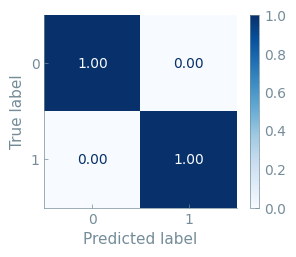

In [71]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

#plt.rcParams.update({'font.size': 9})
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_number_atoms_confusionMatrix_2bins_5050_XGBoost.pdf', bbox_inches='tight')